In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import math

In [5]:
BASE_PATH = "/root/GSST-daytime-sky-quality"

In [34]:
def create_variable_dataset(variable, pressure_levels, year_interval):
    datasets = []  # Lista para armazenar os datasets temporários

    for pressure_level in pressure_levels:
        # load dataset
        pl_variable = xr.open_dataset(
            f"{BASE_PATH}/data/Reanalysis_ERA5/Vertical_Profile/{variable}_{pressure_level}hPa_{year_interval}.nc"
        )
        # get mean from lat and lon
        pl_variable = pl_variable.mean(dim=['latitude', 'longitude'])
        
        # Add the pressure level dimension with the current pressure_level value
        pl_variable_expanded = pl_variable.expand_dims("pressure_level")
        pl_variable_expanded['pressure_level'] = [pressure_level]
        
        # Store the expanded dataset in the list
        datasets.append(pl_variable_expanded)

    # Concatenate all datasets along the new 'pressure_level
    variable_dataset = xr.concat(datasets, dim="pressure_level")

    return variable_dataset

pressure_levels = [
    1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000
]

def create_pl_dataset_by_year_interval(year_interval):
    temperature = create_variable_dataset("temperature", pressure_levels, year_interval)
    # rename the variable
    temperature = temperature.rename_vars({"t": "temperature"})

    relative_humidity = create_variable_dataset("relative_humidity", pressure_levels, year_interval)
    relative_humidity = relative_humidity.rename_vars({"r": "relative_humidity"})

    specific_humidity = create_variable_dataset("specific_humidity", pressure_levels, year_interval)
    specific_humidity = specific_humidity.rename_vars({"q": "specific_humidity"})

    u_component_of_wind = create_variable_dataset("u_component_of_wind", pressure_levels, year_interval)
    v_component_of_wind = create_variable_dataset("v_component_of_wind", pressure_levels, year_interval)

    # geopotential = create_variable_dataset("geopotential", pressure_levels, year_interval)
    # geopotential = geopotential.rename_vars({"z": "geopotential"})
    # concatenate all variables
    vertical_profile_ds = xr.merge([
        temperature, 
        relative_humidity, 
        specific_humidity, 
        u_component_of_wind, 
        v_component_of_wind, 
        # geopotential
    ])

    return vertical_profile_ds

vertical_profile_ds = xr.merge([
    create_pl_dataset_by_year_interval("1999_2003"),
    # create_pl_dataset_by_year_interval("2004_2008"),
    # create_pl_dataset_by_year_interval("2009_2013"),
    # create_pl_dataset_by_year_interval("2014_2018"),
    # create_pl_dataset_by_year_interval("2019_2023"),
])

vertical_profile_ds

<xarray.Dataset> Size: 20MB
Dimensions:            (pressure_level: 11, time: 43824)
Coordinates:
  * time               (time) datetime64[ns] 351kB 1999-01-01 ... 2003-12-31T...
  * pressure_level     (pressure_level) int64 88B 1 100 200 300 ... 800 900 1000
Data variables:
    temperature        (pressure_level, time) float64 4MB 266.8 266.1 ... 301.1
    relative_humidity  (pressure_level, time) float64 4MB 0.0001644 ... 82.79
    specific_humidity  (pressure_level, time) float64 4MB 3.764e-06 ... 0.01487
    u                  (pressure_level, time) float64 4MB -53.12 ... -0.73
    v                  (pressure_level, time) float64 4MB -1.046 ... 0.3606

In [37]:
# Carregar dados
ds = vertical_profile_ds[['u']]

# Selecione a componente de vento e faça a média ao longo do tempo
u_component = ds['u'].mean(dim='time')

# Aplicar FFT no perfil vertical
fft_result = np.fft.fft(u_component)
frequencies = np.fft.fftfreq(len(u_component), d=(u_component['pressure_level'][1] - u_component['pressure_level'][0]))

# Encontrar a frequência dominante no espectro (parte positiva)
positive_freqs = frequencies[:len(frequencies)//2]
positive_fft = np.abs(fft_result)[:len(frequencies)//2]
dominant_frequency_index = np.argmax(positive_fft)
f_L = abs(positive_freqs[dominant_frequency_index])

# Mostrar resultado
print(f"Dominant vertical spatial frequency f_L: {f_L} cycles per unit of pressure level")

# Plotar o espectro de frequência
plt.figure(figsize=(10, 4))
plt.plot(positive_freqs, positive_fft)
plt.title('FFT of Vertical Wind Profile')
plt.xlabel('Frequency (cycles per pressure unit)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

ValueError: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([ 0.      ,  0.000918,  0.001837,  0.002755,  0.003673,  0.004591,
       -0.004591, -0.003673, -0.002755, -0.001837, -0.000918])

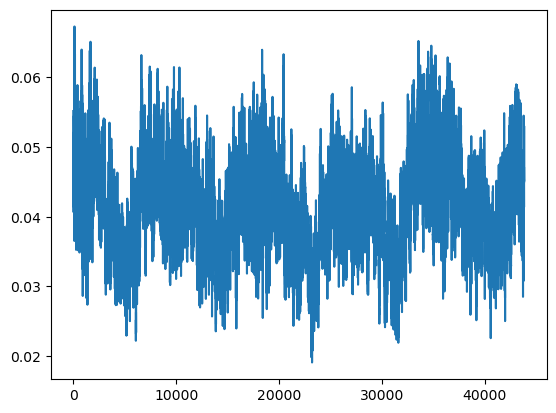

In [32]:
def calculate_ct2(ds, beta=0.1):
    # Calcule o gradiente vertical de temperatura
    temperature_gradient = ds['temperature'].diff(dim='pressure_level') / ds['pressure_level'].diff(dim='pressure_level')

    # Estimate C_T^2
    ct2 = beta * temperature_gradient**2

    return ct2


plt.plot(calculate_ct2(vertical_profile_ds).values[0, :])

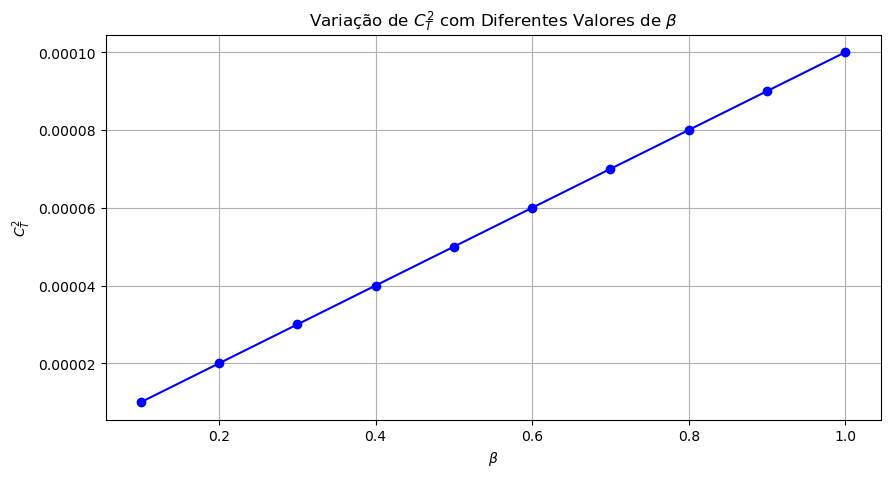

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Dados hipotéticos de gradiente vertical de temperatura
temperatura_gradiente = 0.01  # Em K/m, um valor constante para simplificação

# Definindo uma gama de valores para beta
betas = np.linspace(0.1, 1.0, 10)  # de 0.1 a 1.0 com 10 valores

# Calculando CT^2 para cada valor de beta
CT2_values = [beta * temperatura_gradiente**2 for beta in betas]

# Plotando os resultados
plt.figure(figsize=(10, 5))
plt.plot(betas, CT2_values, marker='o', linestyle='-', color='b')
plt.title('Variação de $C_T^2$ com Diferentes Valores de $\\beta$')
plt.xlabel('$\\beta$')
plt.ylabel('$C_T^2$')
plt.grid(True)
plt.show()


In [19]:
# calculating structure parameter of air temperature fluctuations (CT2)

def calculate_ct2(ds):
    # calculate the mean temperature
    temperature_mean = ds.temperature.mean(dim="pressure_level")

    # calculate the temperature fluctuations
    temperature_fluctuations = ds.temperature - temperature_mean
    
    # calculate the square of the temperature fluctuations
    temperature_fluctuations_squared = temperature_fluctuations ** 2
    
    # calculate the mean of the square of the temperature fluctuations
    ct2 = temperature_fluctuations_squared.mean(dim="pressure_level")
    
    return ct2


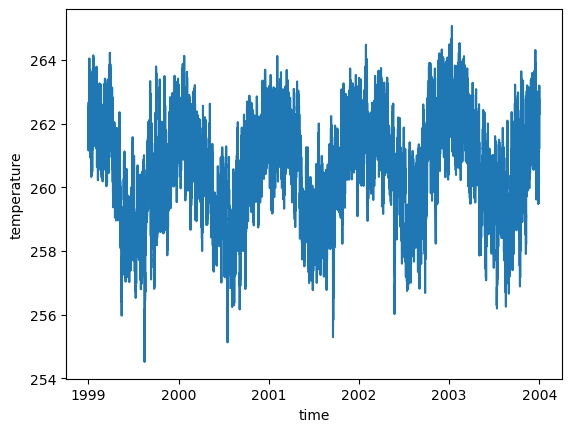

In [23]:
vertical_profile_ds.mean(dim="pressure_level").temperature.plot()

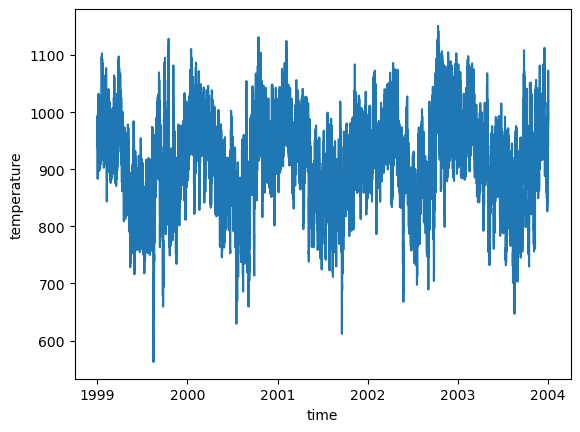

In [22]:
calculate_ct2(vertical_profile_ds).plot()